In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from open3d import *
import os
import sys
from PIL import Image
import time
import heapq
import matplotlib.patches as patches
import cv2
import heapq
from open3d.visualization import draw_geometries
from open3d.geometry import PointCloud, LineSet
from open3d.utility import Vector3dVector, Vector2iVector
import plyfile

## Chargement des données de caméra et des points :
#### Les données des caméras et des points à partir desquels la reconstruction est effectuée sont chargées à partir de fchiers textes spécifiés.


In [2]:
#%% read LiuHong_Camera_index_R_T file
def load_camera_data():
    file = open('./LiuHong_Camera_index_R_T.txt','r')
    lines = file.readlines()

    for i in range(len(lines)):
        lines[i] = lines[i].rstrip('\n')

    title = np.double(lines[0].split(' '))
    camera_num = int(title[0])
    pixel_num = int(title[1])
    R = np.empty([camera_num,3,3])
    f = np.empty(camera_num)
    t = np.empty([camera_num,3])

    i = 1
    j = 0
    while i < len(lines):
        f[j] = np.double(lines[i].split(' '))[0]
        R[j,0,:] = np.double(lines[i+1].split(' '))
        R[j,1,:] = np.double(lines[i+2].split(' '))
        R[j,2,:] = np.double(lines[i+3].split(' '))
        t[j,:] = np.double(lines[i+4].split(' '))
        j+=1
        i+=5
    return camera_num,pixel_num,f,R,t

In [3]:
def load_point_data():
    camera_num,pixel_num,f,R,t = load_camera_data()
    file = open('./LiuHong_Point_Collect.txt','r')
    lines = file.readlines()
    for i in range(len(lines)):
        lines[i] = lines[i].rstrip('\n')
    point_color = np.empty([pixel_num,3]).astype(int)
    point_position = np.empty([pixel_num,3])
    point_camera = []
    point_2dlocation = []
    i = 0
    j = 0
    while i < pixel_num:
        point_position[i,:] = np.double(lines[j].split(' '))
        j += 1
        point_color[i,:] = np.array(lines[j].split(' ')).astype(int)
        j += 1

        info = list(np.double(lines[j].split(' ')))
        num = info[0]
        info = info[1:]
        while len(info)/3 < num:
            j+=1
            info = info +  list(np.double(lines[j].split(' ')))
        k = 0
        index_camera = []
        location = []
        while k < len(info):
            index_camera.append(info[k])
            k+=2
            location.append(info[k])
            k+=1
            location.append(info[k])
            k+=1
        point_camera.append(index_camera)
        point_2dlocation.append(location)
        j +=1
        i += 1

    return point_position, point_color,point_2dlocation,point_camera

## Calcul des centres de caméra :
#### Les centres des caméras sont calculés à partir des données de caméra chargées.

In [4]:
#%% calculate the camera center
camera_num,pixel_num,f,R,t = load_camera_data()
center = np.empty([camera_num,3])
vector = np.empty([camera_num,6])
for i in range(camera_num):
    center[i,:] = np.dot(-R[i,:,:].T,t[i,:])
    vector[i,0:3] = np.dot(-R[i,:,:].T,t[i,:])
    vector[i,3:6] = np.dot(R[i,:,:].T,np.array([0,0,1]).reshape(3,))

## Visualisation des caméras dans un repère 3D :
#### Les centres de caméra calculés sont visualisés dans un espace 3D.

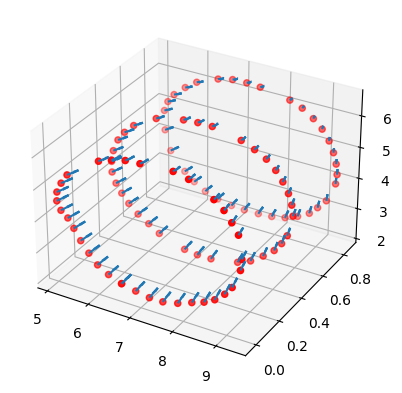

In [5]:
#%% test the camera location in Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(center[:,0],center[:,1],center[:,2],c='r')
ax.quiver(vector[:,0],vector[:,1],vector[:,2],-vector[:,3],-vector[:,4],-vector[:,5],length = 0.1,arrow_length_ratio = 0.5)
ax.pbaspect = [1.0, 1.0, 1.0]

## Chargement des données éparses et denses :
#### Les données de points éparses et denses sont chargées à partir de fchiers PLY.

In [6]:
#%% load sparse data
def sparse_recon():
    point_position, point_color,point_2dlocation,point_camera = load_point_data()
    xyz = np.double(point_position)
    xyz = np.concatenate((center,xyz))
    camera_color = np.array([[0.,0.,255.],]*camera_num)
    point_color = np.concatenate((camera_color,point_color))
    pcd = PointCloud()
    pcd.points = Vector3dVector(xyz)
    pcd.colors = Vector3dVector(point_color/255.)
    draw_geometries([pcd])
    return xyz,point_color
#%% visualize the dense cloud point
def dense_recon():
    plydata = plyfile.PlyData.read('./point-3D.ply')
    x = np.double(plydata.elements[0].data['x'])
    x = x.reshape(len(x),1)
    y = np.double(plydata.elements[0].data['y'])
    y = y.reshape(len(y),1)
    z = np.double(plydata.elements[0].data['z'])
    z = z.reshape(len(z),1)
    r= np.double(plydata.elements[0].data['diffuse_red'])
    r = r.reshape(len(r),1)
    g= np.double(plydata.elements[0].data['diffuse_green'])
    g = g.reshape(len(r),1)
    b= np.double(plydata.elements[0].data['diffuse_blue'])
    b = b.reshape(len(r),1)
    xyz = np.concatenate((x,y,z),axis = 1)
    rgb = np.concatenate((r,g,b),axis = 1)
    #camera center recover
    xyz = np.concatenate((center,xyz))
    camera_color = np.array([[0.,0.,255.],]*camera_num)
    rgb = np.concatenate((camera_color,rgb))
    pcd = PointCloud()
    pcd.points = Vector3dVector(xyz)
    pcd.colors = Vector3dVector(rgb/255.)
    draw_geometries([pcd])
    return xyz,rgb

In [7]:
#%% load model
sift = cv2.xfeatures2d.SIFT_create()
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
num_matches= []


#%% test_image load
def load_test(test_dir):
    test_image = cv2.imread(test_dir)
    test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2GRAY)
    kp1, des1 = sift.detectAndCompute(test_image,None)
    return test_image,kp1,des1


[ WARN:0@1.735] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


## Détection de référence :
#### Les caractéristiques SIFT (Scale-Invariant Feature Transform) sont détectées dans les images de référence.

In [8]:

# Function to detect reference keypoints and descriptors
def detect_reference():
    # Initialize lists to store keypoints, descriptors, and image names
    ref_kp = []
    ref_des = []
    global reference_name  # Declare reference_name as global to access it outside the function
    reference_dir = './reference_image'
    
    # List comprehension to convert image names into absolute paths
    reference_name = [os.path.join(reference_dir, ele) for ele in os.listdir(reference_dir)]
    
    # Initialize SIFT object
    sift = cv2.xfeatures2d.SIFT_create()
    
    # Loop through each reference image
    for j, ref_image_path in enumerate(reference_name):
        # Read the image
        a = cv2.imread(ref_image_path)
        
        # Check if the image is successfully loaded
        if a is None:
            print(f'Error: Failed to load image {ref_image_path}')
            continue
        
        # Convert the image to grayscale
        a_gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
        
        # Detect keypoints and compute descriptors
        kp, des = sift.detectAndCompute(a_gray, None)
        
        # Append keypoints and descriptors to lists
        ref_kp.append(kp)
        ref_des.append(des)
        
        # Print progress
        print(f'Processed image {j+1}/{len(reference_name)}')
    
    return ref_kp, ref_des,reference_name


## Mise en correspondance des caractéristiques : 
#### Les caractéristiques de l'image de test sont mises en correspondance avec celles des images de référence à l'aide de l'algorithme FLANN (Fast Library for Approximate Nearest Neighbors).

In [9]:
# Function to match test image with reference images
def match_all(ref_kp, ref_des, des1,reference_name):
    num_matches = []
    
    # Debugging step 1: Check if reference keypoints and descriptors lists are empty
    if len(ref_kp) == 0 or len(ref_des) == 0:
        print("Error: Reference keypoints or descriptors list is empty")
        return num_matches
    
    for j in range(len(reference_name)):
        # Debugging step 2: Verify if reference keypoints and descriptors are populated correctly
        if j >= len(ref_kp) or j >= len(ref_des):
            print(f"Error: Index {j} out of range for reference keypoints or descriptors list")
            continue
        
        des2 = ref_des[j]
        
        # Debugging step 3: Confirm if reference images are loaded successfully
        print(f"Processing reference image {j+1}/{len(reference_name)}: {reference_name[j]}")
        
        matches = flann.knnMatch(des1, des2, k=2)
        matchesMask = [[0,0] for i in range(len(matches))]
        k = 0
        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7 * n.distance:
                matchesMask[i] = [1,0]
                k += 1
        num_matches.append(k)
        print(k)
        print(j)
    return num_matches

#%% visualizae the hist graph
def visual_hist(num_matches):
    plt.figure(1,figsize = (6,3))
    x_pos = np.arange(len(num_matches))
    plt.bar(x_pos,num_matches)
    #pick heightest 5 histgrom
    valid_index = heapq.nlargest(5, range(len(num_matches)), np.asarray(num_matches).take)
    valid_matches = []
    for i in range(len(valid_index)):
        valid_matches.append(num_matches[valid_index[i]])
    plt.bar(valid_index,valid_matches,color = (1.0,0,0,1))

    
#convert int list to string
    def convert(s):
        new = ""
        for x in s:
            new += str(x)+ " "
        return new
    valid_index_print = convert(valid_index)
    plt.title(['heighest matches images ' + valid_index_print])
    plt.xlabel('image name')
    plt.ylabel('matches_point')
    return valid_index

#%% visulize the highest matches picture
def visual_match(valid_index,ref_kp,ref_des,kp1,des1,test_dir,reference_name):
    for j in range(len(valid_index)):
        highest_index = valid_index[j]
        kp2 = ref_kp[highest_index]
        des2 = ref_des[highest_index]
        matches = flann.knnMatch(des1,des2,k=2)
        Mask = [[0,0] for i in range(len(matches))]
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                Mask[i]=[1,0]
        draw_params = dict(matchColor = (0,255,0),
                           singlePointColor = (255,0,0),
                           matchesMask = Mask,
                           flags = 0)
        image1 = cv2.imread(test_dir)
        image2 = cv2.imread(reference_name[highest_index])
        img3 = cv2.drawMatchesKnn(image1,kp1,image2,kp2,matches,None,**draw_params)
        print(j)
        plt.figure(j)
        plt.imshow(img3)

## Élimination des valeurs aberrantes : 
#### Les valeurs aberrantes sont supprimées des points appariés entre l'image de test et les images de référence.

In [10]:
#%% remove outlier
def remove_out(valid_index,ref_kp,ref_des,kp1,des1,test_image):
    matched_point_all_image = []
    q,t = test_image.shape
    for i in range(len(valid_index)):
        index = valid_index[i]
        kp2 = ref_kp[index]
        des2 = ref_des[index]
        matches = flann.knnMatch(des1,des2,k=2)
        matched_point = []
        for j,(m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                pt = kp2[m.trainIdx].pt
                matched_point.append(pt)
        matched_point = np.asarray(matched_point)
        distance = np.sqrt(np.sum(matched_point**2,axis=1))
        mean = np.mean(distance)
        std = np.std(distance)
        low = mean - std
        high = mean + std
        good_point_index = np.where(np.logical_and(distance>= low,distance <= high))
        matched_point_filtered = matched_point[good_point_index]
        matched_point_all_image.append(matched_point_filtered)
    return matched_point_all_image


#%% get 2d location matches in 2d sparse camera
def camera2d_point_loc(valid_index,point_camera,matched_point,point_2dlocation,point_position):
    good_point = []
    for i in range(len(valid_index)):
        camera = valid_index[i]
        refe_point = matched_point[i]
        x = refe_point[:,0]
        y = refe_point[:,1]
        x_min = np.min(x)
        x_max = np.max(x)
        y_min = np.min(y)
        y_max = np.max(y)
        j = 0
        while j < len(point_camera):
            try:
                index = point_camera[j].index(camera)
                x1 = point_2dlocation[j][2*index]+4797/2.
                y1 = point_2dlocation[j][2*index+1]+3598/2.
                if (x1>=x_min and x1<=x_max and y1>=y_min and y1<=y_max):
                    good_point.append(point_position[j])
                j += 1
            except:
                j += 1

    return good_point

#%% get repeated point from good point
def compute_center(good_point):
    good_point = np.asarray(good_point)

    return np.mean(good_point,axis = 0), np.std(good_point,axis = 0)

#%% projection matrix
def get_projections(valid_index):
    k = 0
    txt_name ='000000'
    proj_m = np.zeros((100, 3, 4))
    for i in range(100):
        if(i < 10):
            name = txt_name + '0'+ str(k) + '.txt'
        else:
            name = txt_name + str(k) + '.txt'
        file = open('./txt/' + name, 'r')
        lines = file.readlines()[1:] #To skip 1 line
        mat = []
        for j in range(0, len(lines),3):
            for z in range(3):
                mat.append(list(map(float,lines[j+z].split())))
        proj_m[k] = mat
        k +=1
    new_proj = []
    for i in range(len(valid_index)):
        new_proj.append(proj_m[valid_index[i]])
    return new_proj

## Calcul de la région de test dans chaque image :
#### Les coordonnées de la région de test sont calculées dans chaque image de référence en fonction des points appariés.

In [11]:
#%% calculate the rectangle region in each image
def rect_cal(matched_point):
    x_min = []
    x_max = []
    y_min = []
    y_max = []
    for i in range(len(matched_point)):
        point = matched_point[i]
        x_min.append(np.min(point[:,0]))
        y_min.append(np.min(point[:,1]))
        x_max.append(np.max(point[:,0]))
        y_max.append(np.max(point[:,1]))
    return x_min,x_max,y_min,y_max


#%% visualize each image with rectangle
def visual_rect(x_min,x_max,y_min,y_max,valid_index,reference_name):
    for i in range(len(valid_index)):
        left_corner = (x_min[i],y_min[i])
        width = x_max[i] - x_min[i]
        height = y_max[i] - y_min[i]
        fig = plt.figure(i)
        ax = fig.add_subplot(111)
        img = cv2.imread(reference_name[valid_index[i]])
        ax.imshow(img)
        rect = patches.Rectangle(left_corner,width,height,fill=False,edgecolor='r')
        ax.add_patch(rect)

## Détection SIFT dans la région de test :
#### Les caractéristiques SIFT sont détectées dans la région de test de chaque image de référence.

In [12]:
       
#%% sift detection within region
def d3_point_calculate(ref_des,ref_kp,x_min,x_max,y_min,y_max,valid_index):
    kp_all = []
    des_all = []
    for i in range(len(valid_index)):
        des = ref_des[valid_index[i]]
        kp = ref_kp[valid_index[i]]
        new_kp = []
        new_des = []
        for j in range(len(kp)):
            if kp[j].pt[0] > x_min[i] and kp[j].pt[0] < x_max[i] and kp[j].pt[1] > y_min[i] and kp[j].pt[1] < y_max[i]:
                new_kp.append(kp[j])
                new_des.append(des[j])
        new_kp = np.asarray(new_kp)
        new_des = np.asarray(new_des)
        kp_all.append(new_kp)
        des_all.append(new_des)
    return kp_all,des_all

## Mise en correspondance des caractéristiques dans la région de test :
#### Les caractéristiques de la région de test sont mises en correspondance entre les différentes images de référence.

In [13]:
#%% matching between region
def region_detect(kp_all,des_all,valid_index):
    result = []
    for i in range(len(valid_index)-1):
        for j in range(i+1,len(valid_index)):
            kp1 = kp_all[i]
            kp2 = kp_all[j]
            des1 = des_all[i]
            des2 = des_all[j]
            cam1 = valid_index[i]
            cam2 = valid_index[j]
            matches = flann.knnMatch(des1,des2,k=2)
            pt1 = []
            pt2 = []
            for s,(m,n) in enumerate(matches):
                if m.distance < 0.7*n.distance:
                    pt1.append(kp1[m.queryIdx].pt)
                    pt2.append(kp2[m.trainIdx].pt)
            result.append([pt1,pt2,i,j])
    return result

## Triangulation des points :
#### Les points 3D sont calculés à partir des correspondances entre les différentes régions de test dans les images de référence.

In [14]:
#%% use trigulation method to get 3d coordinate
def tri_method(region_match,proj):
    points = []
    for i in range(len(region_match)):
        data = region_match[i]
        cam1 = data[2]
        cam2 = data[3]
        p1 = proj[cam1]
        p2 = proj[cam2]
        point2d1 = np.asarray(data[0]).T
        point2d2 = np.asarray(data[1]).T
        d3_point = cv2.triangulatePoints(p1,p2,point2d1,point2d2)
        d3_point = d3_point[0:3,:]/d3_point[3,:]
        points.append(d3_point.T)
    d3_point = np.concatenate((points[0],points[1],points[2],points[3],points[4]),axis = 0)

    return d3_point

## Filtrage des points 3D : 
#### Les points 3D sont filtrés pour éliminer les valeurs aberrantes.

In [15]:
#%% remove out for final result
def remove_out2(d3_point):

    distance = np.sqrt(np.sum(d3_point**2,axis=1))
    mean = np.mean(distance)
    std = np.std(distance)
    low = mean - std
    high = mean + std
    good_point_index = np.where(np.logical_and(distance>= low,distance <= high))
    d3_point = d3_point[good_point_index]

    return d3_point

# Visualisation des résultats 

In [16]:

#%% test image dir
test_dir = './cropped_test_image/test3.jpg'

#%% preload sift of reference if not exist
print('No preloaded model, sift detecting the reference image now............')

# First, detect the reference keypoints and descriptors
ref_kp, ref_des,reference_name = detect_reference()
print('Finished the sift detection of the reference image')

#%% load test image data, just 1 image
print('load the test image.........')
test_image,kp1,des1 = load_test(test_dir)
print('Finished load the test image')

#%% preview the reference 3d data
print('previewing the sparse reconstruction data');sparse_recon()
print('previewing the reference data.....');xyz,rgb = dense_recon()

No preloaded model, sift detecting the reference image now............


KeyboardInterrupt: 

matching the test image with reference
Processing reference image 1/101: ./reference_image/00000038.jpg


1
0
Processing reference image 2/101: ./reference_image/00000010.jpg
2
1
Processing reference image 3/101: ./reference_image/00000004.jpg
10
2
Processing reference image 4/101: ./reference_image/00000005.jpg
5
3
Processing reference image 5/101: ./reference_image/00000011.jpg
6
4
Processing reference image 6/101: ./reference_image/00000039.jpg
46
5
Processing reference image 7/101: ./reference_image/00000007.jpg
14
6
Processing reference image 8/101: ./reference_image/00000013.jpg
2
7
Processing reference image 9/101: ./reference_image/00000012.jpg
3
8
Processing reference image 10/101: ./reference_image/00000006.jpg
4
9
Processing reference image 11/101: ./reference_image/00000002.jpg
46
10
Processing reference image 12/101: ./reference_image/00000016.jpg
2
11
Processing reference image 13/101: ./reference_image/.DS_Store
2
12
Processing reference image 14/101: ./reference_image/00000017.jpg
9
13
Processing reference image 15/101: ./reference_image/00000003.jpg
1
14
Processing referen

/var/folders/15/h3fnbps53tzbnscmzvg18w580000gn/T/ipykernel_62290/1968364993.py:7: RuntimeWarning: invalid value encountered in cast
  point_color = np.empty([pixel_num,3]).astype(int)


Load the projection matrix
Calculate test area in each image
visulize the test region
sift detection with in region
flann matching within region
Get 3D point
filter 3D point
draw the final graph for visual


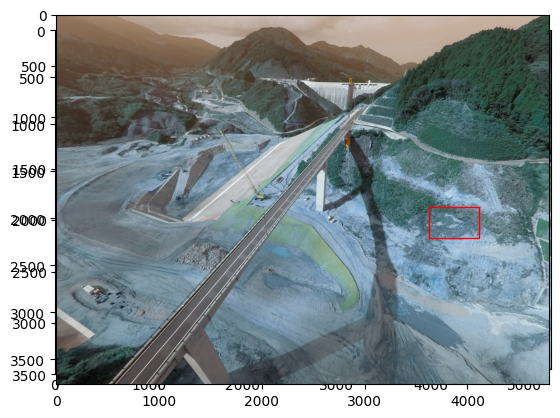

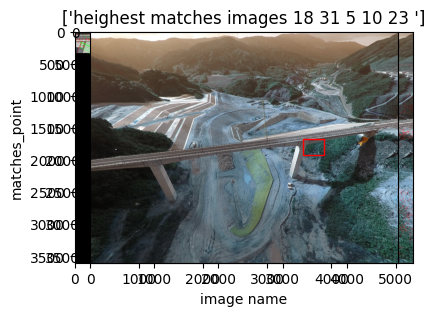

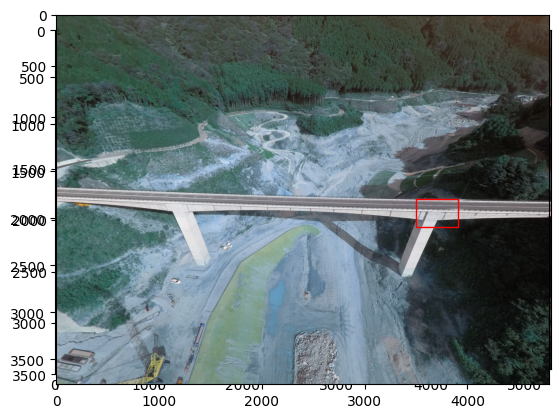

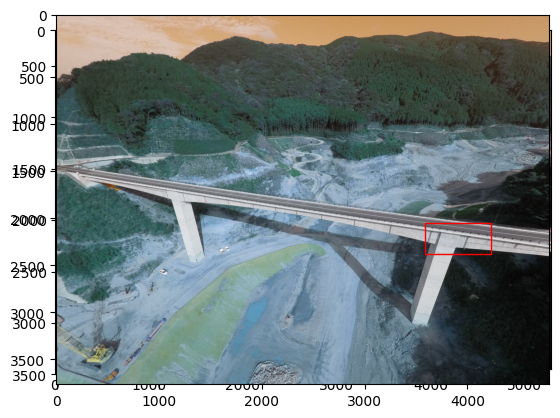

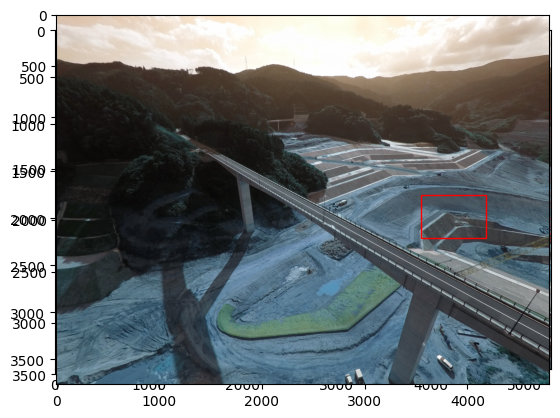

: 

In [ ]:
#%% try match the test image and reference image and visualize as histogram
print('matching the test image with reference');num_matches = match_all(ref_kp,ref_des,des1,reference_name)
print('Finished matching the test image with reference');valid_index = visual_hist(num_matches)
print('Drawing highest score matching');visual_match(valid_index,ref_kp,ref_des,kp1,des1,test_dir,reference_name)

#%% remove the out lier from the matching data
print('Remove outlier and get matched point in all valid index image');matched_point = remove_out(valid_index,ref_kp,ref_des,kp1,des1,test_image)
print('Load the sparse reconstruction information');point_position, point_color,point_2dlocation,point_camera = load_point_data()
print('Load the projection matrix');proj = get_projections(valid_index)
print('Calculate test area in each image');x_min,x_max,y_min,y_max = rect_cal(matched_point)
print('visulize the test region');visual_rect(x_min,x_max,y_min,y_max,valid_index,reference_name)
print('sift detection with in region');kp_all,des_all = d3_point_calculate(ref_des,ref_kp,x_min,x_max,y_min,y_max,valid_index)
print('flann matching within region');region_match = region_detect(kp_all,des_all,valid_index)

#%% triangulate the point
print('Get 3D point');d3_point = tri_method(region_match,proj)
print('filter 3D point');d3_point = remove_out2(d3_point)

#%% draw the box on 3d point cloud
def draw_box(d3_point,xyz,rgb):
    mean = np.mean(d3_point,axis =0)
    minv = np.min(d3_point,axis = 0)
    maxv = np.max(d3_point,axis = 0)
    mean = (maxv+minv)/2
    std = np.mean(np.std(d3_point,axis =0))
    sigma = 10*std
    x = mean[0]-sigma
    y = mean[1]-sigma
    z = mean[2]-sigma
    points = [[x,y,z],[x+sigma,y,z],[x,y+sigma,z],[x+sigma,y+sigma,z],
              [x,y,z+sigma],[x+sigma,y,z+sigma],[x,y+sigma,z+sigma],[x+sigma,y+sigma,z+sigma]]
    lines = [[0,1],[0,2],[1,3],[2,3],
             [4,5],[4,6],[5,7],[6,7],
             [0,4],[1,5],[2,6],[3,7]]
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set = LineSet()
    line_set.points = Vector3dVector(points)
    line_set.lines = Vector2iVector(lines)
    line_set.colors = Vector3dVector(colors)
    re = PointCloud()
    re.points = Vector3dVector(xyz)
    re.colors = Vector3dVector(rgb/255.)
    draw_geometries([line_set,re])
print('draw the final graph for visual');draw_box(d3_point,xyz,rgb)